필요한 라이브러리 import 및 데이터 가져오기

In [27]:
import json
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import sys
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import Text
import collections
from tensorflow.keras.layers import Dense, SpatialDropout1D, Conv1D, Embedding, LSTM, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.preprocessing.sequence import pad_sequences 
from keras.utils import np_utils 
from sklearn.model_selection import train_test_split


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stops = set(stopwords.words('english'))
stemmer = nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


데이터 진행 과정 확인을 위한 Progress Bar Util

In [28]:
def printProgress (iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100):
    formatStr = "{0:." + str(decimals) + "f}"
    percent = formatStr.format(100 * (iteration / float(total)))
    filledLength = int(round(barLength * iteration / float(total)))
    bar = '#' * filledLength + '-' * (barLength - filledLength)
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percent, '%', suffix)),
    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

json 데이터 가져오기

In [29]:
with open('friends_train.json') as json_file:
    json_train = json.load(json_file)
with open('friends_test.json') as json_file:
    json_test = json.load(json_file)
with open('friends_dev.json') as json_file:
    json_dev = json.load(json_file)

영어 데이터 전처리 함수

In [30]:
def cleaning(str):
    replaceAll = str
    only_english = re.sub('[^a-zA-Z]', ' ', replaceAll)
    no_capitals = only_english.lower().split()
    no_stops = [word for word in no_capitals if not word in stops]
    stemmer_words = [stemmer.stem(word) for word in no_stops]
    return ' '.join(stemmer_words)

트레이닝용 데이터 생성

In [31]:
i = 0
train_data=[]
for rows in json_train:
    for row in rows:
        train_data.append([cleaning(row['utterance']), row['emotion']])
for rows in json_test:
    for row in rows:
        train_data.append([cleaning(row['utterance']), row['emotion']])
for rows in json_dev:
    for row in rows:
        train_data.append([cleaning(row['utterance']), row['emotion']])

품사 태깅

In [32]:
cnt = 0
tagged = []
counter = collections.Counter()
for d in train_data:
    cnt = cnt + 1
    printProgress(cnt, len(train_data), 'Progress:', 'Complete', 1, 100)
    words = pos_tag(word_tokenize(d[0]))
    for t in words:
        word = "/".join(t)
        tagged.append(word)
        counter[word] += 1

Progress: |####################################################################################################| 100.0% Complete


카운팅 끝난 후, 임베딩

In [33]:
VOCAB_SIZE = 5000
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

감정을 번호로, 번호를 감정으로 변환해주는 함수

In [34]:
def labeltoint(str):
    return {'non-neutral': 0,
             'neutral': 1, 
             'joy': 2,
             'sadness': 3,
             'fear': 4,
             'anger': 5,
             'surprise': 6,
             'disgust': 7}[str]

In [35]:
def inttolabel(idx):
    return {0:'non-neutral',
             1:'neutral', 
             2:'joy',
             3:'sadness',
             4:'fear',
             5:'anger',
             6:'surprise',
             7:'disgust'}[idx]

트레이닝 데이터의 emotion value를 모두 숫자로 변환

In [36]:
xs, ys = [], []
cnt = 0
maxlen = 0
for d in train_data:
    cnt = cnt + 1
    ys.append(labeltoint(d[1]))
    printProgress(cnt, len(train_data), 'Progress:', 'Complete', 1, 100)
    ang = pos_tag(word_tokenize(d[0]))
    words=[]
    for t in ang:
        words.append("/".join(t))
    if len(words) > maxlen: 
        maxlen = len(words)
    wids = [word2index[word] for word in words]
    xs.append(wids)

Progress: |####################################################################################################| 100.0% Complete


X,Y 에 최종적인 train data와 train label 투입 후, 모델 생성

In [37]:
X = pad_sequences(xs, maxlen=maxlen) 
Y = np_utils.to_categorical(ys)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=50)

model = Sequential() 
model.add(Embedding(vocab_sz, 100, input_length=maxlen))
model.add(SpatialDropout1D(0.2)) 
model.add(Conv1D(filters=256, kernel_size=3, activation="relu")) 
model.add(MaxPooling1D(pool_size=4)) 
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) 
model.add(Dense(8, activation="softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]) 

es = EarlyStopping(monitor='val_loss', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(x_train, y_train, epochs=20, batch_size=64, callbacks=[es, mc], validation_data=(x_test, y_test))
# history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/20
159/159 [==============================] - 24s 108ms/step - loss: 1.6710 - accuracy: 0.4433 - val_loss: 1.5719 - val_accuracy: 0.4500

Epoch 00001: val_loss improved from inf to 1.57189, saving model to best_model.h5
Epoch 2/20
159/159 [==============================] - 11s 71ms/step - loss: 1.5000 - accuracy: 0.4674 - val_loss: 1.4850 - val_accuracy: 0.4764

Epoch 00002: val_loss improved from 1.57189 to 1.48504, saving model to best_model.h5
Epoch 3/20
159/159 [==============================] - 11s 71ms/step - loss: 1.2824 - accuracy: 0.5443 - val_loss: 1.5238 - val_accuracy: 0.4590

Epoch 00003: val_loss did not improve from 1.48504
Epoch 4/20
159/159 [==============================] - 11s 71ms/step - loss: 1.1038 - accuracy: 0.6203 - val_loss: 1.6545 - val_accuracy: 0.4647

Epoch 00004: val_loss did not improve from 1.48504
Epoch 5/20
159/159 [==============================] - 11s 71ms/step - loss: 0.9610 - accuracy: 0.6745 - val_loss: 1.8041 - val_accuracy: 0.4344

Epoc

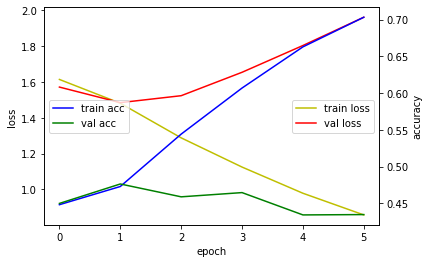

In [38]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='center right')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='center left')

plt.show()

가장 좋은 모델을 기준으로 테스트 데이터 정확도 측정

In [39]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

136/136 [==============================] - 2s 9ms/step - loss: 1.4850 - accuracy: 0.4764

 테스트 정확도: 0.4764


새로운 문장이 들어왔을 때 감정을 분석하는 함수

In [40]:
def sentiment_predict(text): 
    aa = pos_tag(word_tokenize(text))
    pp = []
    for t in aa:
        pp.append("/".join(t))
    wids = [word2index[word] for word in pp]
    x_predict = pad_sequences([wids], maxlen=maxlen) 
    y_predict = loaded_model.predict(x_predict)
    c = 0
    cnt = 0
    for y in y_predict[0]:
        if c < y:
            c = y
            ans = cnt
        cnt += 1
    ans = inttolabel(ans)
    return ans;

Kaggle Sample 데이터를 통한 결과 분류 시작

In [41]:
predict_data = pd.read_csv('data.csv')
total_length = len(predict_data)

cols = ['Id', 'Predicted']
lst = []
for index, row in predict_data.iterrows():
    printProgress(row['id'], total_length, 'Progress:', 'Complete', 1, 100)
    lst.append([row['id'], sentiment_predict(row['utterance'])])

result_df = pd.DataFrame(lst, columns=cols)
print(result_df)

Progress: |####################################################################################################| 99.9% Complete        Id Predicted
0        0   neutral
1        1   neutral
2        2   neutral
3        3   neutral
4        4   neutral
...    ...       ...
1618  1618   neutral
1619  1619   neutral
1620  1620   neutral
1621  1621   neutral
1622  1622   neutral

[1623 rows x 2 columns]


분석된 결과를 CSV 파일로 export

In [42]:
result_df.to_csv('sample.csv', sep=',', index=False)